In [30]:
import pandas as pd
import utils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
eps_methyLImp = 3000
eps_nbp1 = eps_nbp2 = 300

In [3]:
data  = pd.read_csv("../data/filtered_cytosines_freq_preprocessed.tsv", sep='\t')
data

,chromosome,position,OD10,OD11,OD12,OD13,OD14,OD15,OD16,OD17,...,YD20,YD21,YD2,YD3,YD4,YD5,YD6,YD7,YD8,YD9
0,chr1,10497,71.956,93.640,94.410,92.163,86.408,92.143,91.304,69.029,...,92.880,80.769,85.714,73.761,84.277,80.408,94.667,92.623,83.992,89.620
1,chr1,10525,93.704,90.813,95.679,89.375,93.528,95.714,93.103,89.737,...,90.000,87.179,91.081,91.329,92.332,85.537,92.857,89.617,92.073,94.684
2,chr1,10542,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,...,100.000,100.000,100.000,100.000,100.000,100.000,99.647,99.708,99.781,100.000
3,chr1,10589,100.000,NaN,NaN,0.000,100.000,NaN,100.000,NaN,...,NaN,85.714,92.308,NaN,100.000,50.000,0.000,91.379,91.892,81.818
4,chr1,10609,95.455,NaN,NaN,0.000,100.000,NaN,63.636,NaN,...,NaN,85.714,94.737,NaN,100.000,100.000,NaN,96.296,97.222,80.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808443,chrY,59021089,60.563,75.000,90.000,61.429,92.754,56.190,56.604,100.000,...,69.565,65.000,66.038,64.368,72.000,49.275,48.750,80.769,83.333,80.645
2808444,chrY,59026010,85.714,80.247,84.615,80.117,90.909,84.946,81.818,91.045,...,87.234,81.522,77.193,83.065,87.059,77.143,82.308,88.889,77.838,76.923
2808445,chrY,59033031,78.431,91.827,90.196,89.286,84.000,80.000,89.744,72.581,...,90.385,79.592,91.667,94.118,66.667,100.000,95.000,94.737,86.047,85.246
2808446,chrY,59033041,79.167,97.101,86.275,85.185,92.593,92.000,84.615,82.258,...,87.821,83.838,85.714,87.500,88.235,85.714,95.000,73.684,85.366,90.000


In [4]:
map_data = pd.read_csv("../data/hm27.hg19.manifest_preprocessed.bed", sep='\t')
get_chr, get_pos = utils.get_marker_to_chr_and_pos(map_data)

horvath_data = pd.read_csv("../data/gb-2013-14-10-r115-S3_preprocessed.csv", sep='\t')
horvath_chr = horvath_data['marker'].apply(get_chr)
horvath_pos = horvath_data['marker'].apply(get_pos)

In [12]:
slices = []

chromosome_coords = utils.get_chromosome_coords(data.chromosome)
positions = data.position.values

for c, p in zip(horvath_chr, horvath_pos):
    i, j = chromosome_coords[c]
    ind = np.searchsorted(positions[i:j], p)
    if p <= positions[i + ind] <= p + 1 :
        slices.append((ind + i, ind + i + 1))
    else:
        l, r = utils.find_slice(p, eps_nbp2, positions[i:j])
        slices.append((l + i, r + i))

rows_to_impute = np.zeros(len(data), dtype=bool)
for l, r in slices:
    rows_to_impute[l:r] = True

In [13]:
imputed_methyLImp = utils.methyLImp(data, rows_to_impute, eps_methyLImp)

100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


In [17]:
imputed_nbp = utils.impute_nbp(data, eps_nbp1, rows_to_impute[:, None] & np.isnan(data.values[:, 2:].astype(np.float64)))

  0%|          | 0/1057 [00:00<?, ?it/s]/Users/Emiliia.Lekhman/Desktop/project/tests/utils/imputation.py:105: RuntimeWarning: Mean of empty slice
  imputed_data.loc[row, columns[col + 2]] = np.nanmean(values[left:right, col])
100%|██████████| 1057/1057 [00:00<00:00, 7088.48it/s]


In [19]:
imputed_nbp = imputed_nbp.values[:, 2:]

In [20]:
def impute_rows(imputed_data):
    rows = []
    for i, j in slices:
        rows.append(np.mean(imputed_data[i:j], axis=0))
    return np.array(rows)

In [21]:
horvath_features_methyLImp_nbp = impute_rows(imputed_methyLImp)

In [22]:
horvath_features_nbp_nbp = impute_rows(imputed_nbp)

In [37]:
predicted_age_methyLImp_nbp = utils.apply_horvath(horvath_features_methyLImp_nbp.T / 100, horvath_data.coefs.values)

In [38]:
predicted_age_nbp_nbp = utils.apply_horvath(horvath_features_nbp_nbp.T / 100, horvath_data.coefs.values)

Text(0, 0.5, 'predicted age')

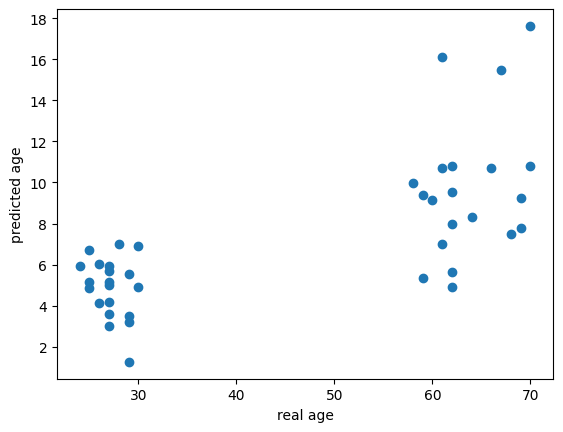

In [39]:
real_age_data = pd.read_csv('../data/RRBS.phase1_yo_datasets.Monocyte.tsv', sep='\t')
real_age_data = real_age_data.sort_values('Donor ID')
real_age = real_age_data['Donor Age']
plt.scatter(real_age, predicted_age_methyLImp_nbp)
plt.xlabel("real age")
plt.ylabel("predicted age")

Text(0, 0.5, 'predicted age')

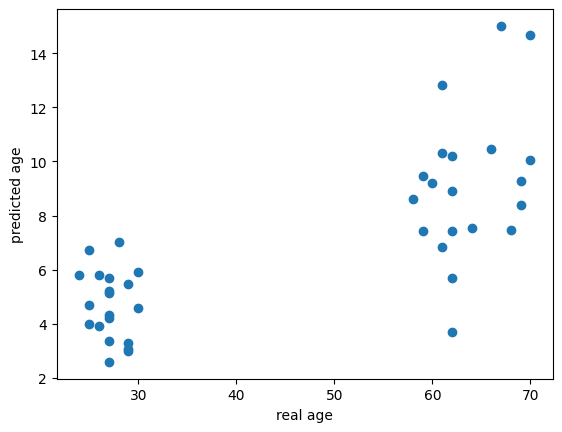

In [40]:
real_age_data = pd.read_csv('../data/RRBS.phase1_yo_datasets.Monocyte.tsv', sep='\t')
real_age_data = real_age_data.sort_values('Donor ID')
real_age = real_age_data['Donor Age']
plt.scatter(real_age, predicted_age_nbp_nbp)
plt.xlabel("real age")
plt.ylabel("predicted age")

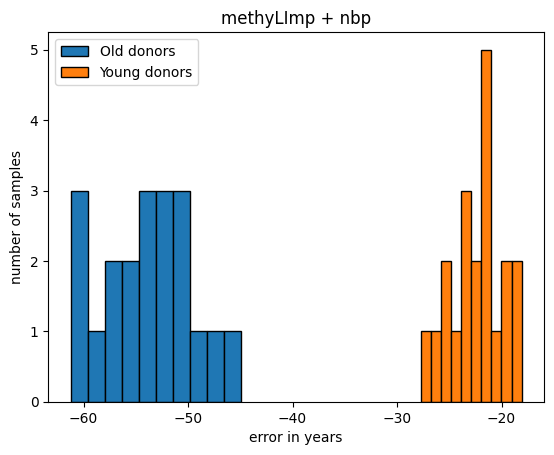

In [45]:
def label(index):
    return 0 if index[0] == "Y" else 1
labels = real_age_data["Donor ID"].apply(label)
errors = predicted_age_methyLImp_nbp - real_age
plt.hist(errors[labels.astype(bool)], ec="k", label="Old donors")
plt.hist(errors[np.invert(labels.astype(bool))], ec="k", label="Young donors")
plt.xlabel("error in years")  
plt.ylabel("number of samples")
plt.title("methyLImp + nbp")
plt.legend()

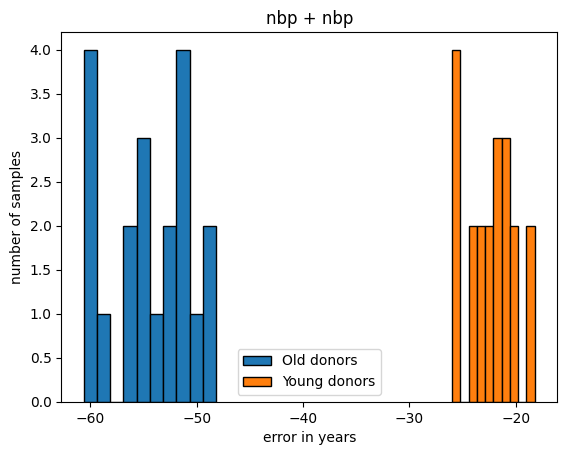

In [44]:
def label(index):
    return 0 if index[0] == "Y" else 1
labels = real_age_data["Donor ID"].apply(label)
errors = predicted_age_nbp_nbp - real_age
plt.hist(errors[labels.astype(bool)], ec="k", label="Old donors")
plt.hist(errors[np.invert(labels.astype(bool))], ec="k", label="Young donors")
plt.xlabel("error in years")  
plt.ylabel("number of samples")
plt.title("nbp + nbp")
plt.legend()